In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import lightning as pl
from lightning import Trainer, LightningModule
from lightning.pytorch.loggers import WandbLogger

import wandb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_parquet("./data/close.parquet")
df

,date,close,high,low
0,2000-01-04,6110,6110,5660
1,2000-01-05,5580,6060,5520
2,2000-01-06,5620,5780,5580
3,2000-01-07,5540,5670,5360
4,2000-01-10,5770,5770,5580
...,...,...,...,...
5833,2023-08-17,66700,66800,66000
5834,2023-08-18,66300,66700,65800
5835,2023-08-21,66600,67100,66300
5836,2023-08-22,66600,67700,66300


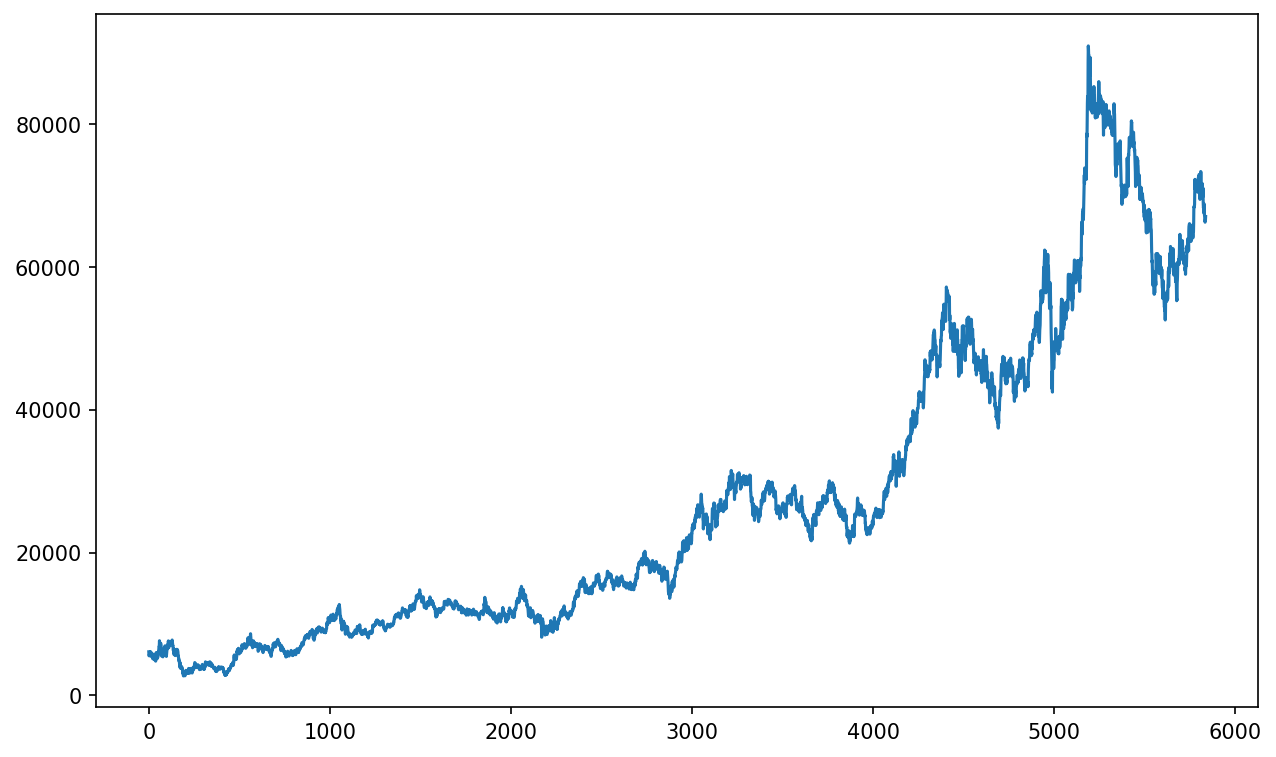

In [3]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(df["close"])
plt.show()

In [4]:
close = df["close"].to_numpy()
close

array([ 6110,  5580,  5620, ..., 66600, 66600, 67100])

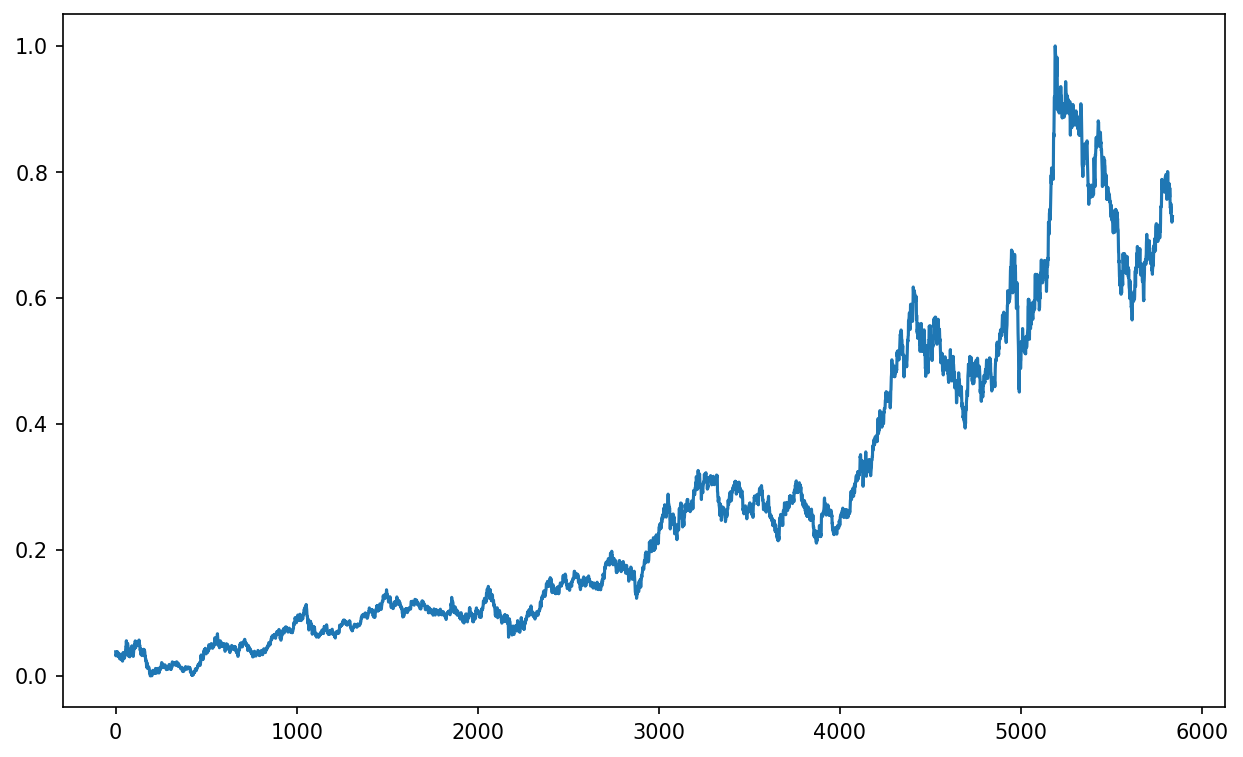

In [5]:
# Normalize
close_max = np.max(close)
close_min = np.min(close)
close = (close - close_min) / (close_max - close_min)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(close)
plt.show()

In [6]:
def sliding_window(data: np.array, window_size: int, horizon: int):
    X = []
    y = []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

In [7]:
X, y = sliding_window(close, 10, 10)

In [8]:
X.shape

(5819, 10)

In [9]:
y.shape

(5819, 10)

In [10]:
def train_test_split(X, y, test_size=0.2):
    split_index = int(len(X) * (1 - test_size))
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
X_train.shape

(4655, 10)

In [13]:
X_test.shape

(1164, 10)

In [24]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

In [25]:
ds_train = StockDataset(X_train, y_train)
ds_test = StockDataset(X_test, y_test)

In [26]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False)

In [27]:
class MLP(LightningModule):
    def __init__(self, input_size, hidden_size, output_size, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.HuberLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.HuberLoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [28]:
model = MLP(10, 32, 10)
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): GELU(approximate='tanh')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='tanh')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='tanh')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='tanh')
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [30]:
# Baseline
y_hat = model(torch.from_numpy(X_test).float())
y_hat = y_hat.detach().numpy()
y_hat.shape

(1164, 10)

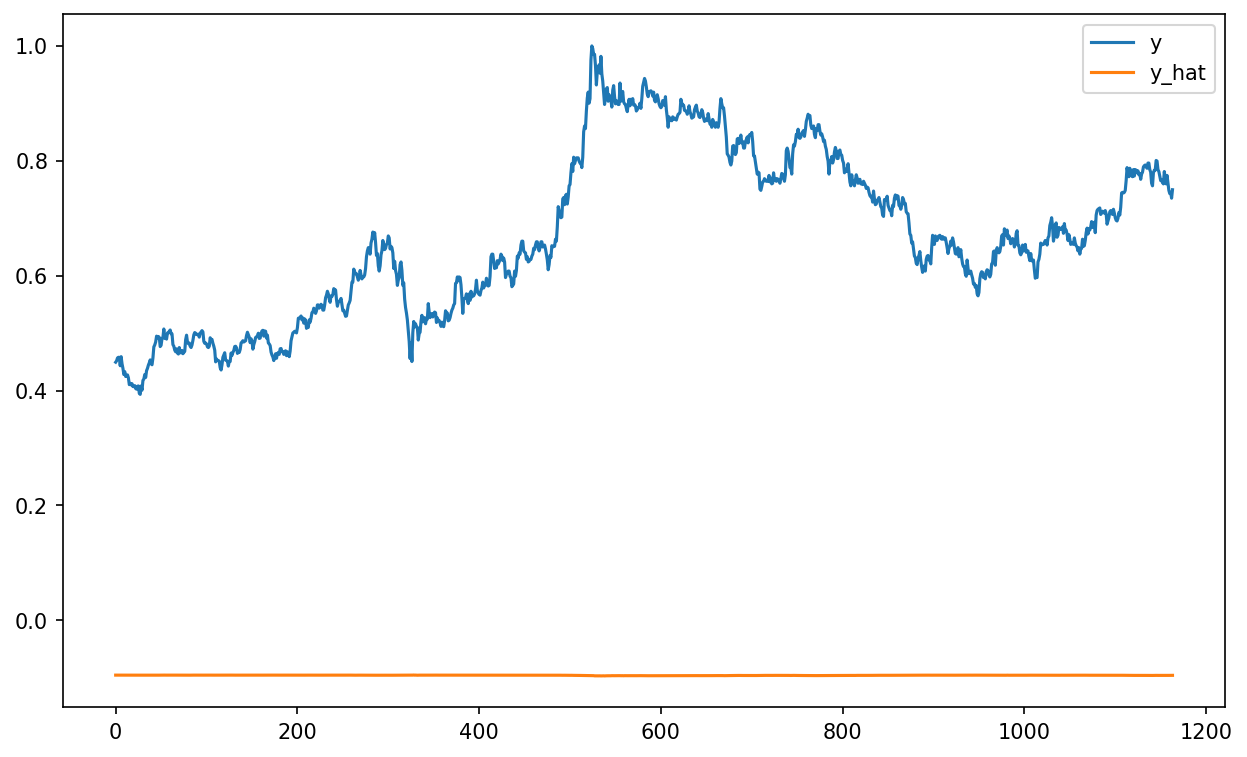

In [31]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y_test[:, 0], label="y")
plt.plot(y_hat[:, 0], label="y_hat")
plt.legend()
plt.show()

In [21]:
# Wandb logger
wandb_logger = WandbLogger(project="stock_test")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [32]:
trainer = Trainer(
    devices=1,
    accelerator='auto',
    max_epochs=100,
    logger=wandb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(model, dl_train, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 3.9 K 
------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.015     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/xteca/Documents/Project/Machine_Learning/MLTest/new/stock_forecasting/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/xteca/Documents/Project/Machine_Learning/MLTest/new/stock_forecasting/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 146/146 [00:00<00:00, 234.32it/s, v_num=zhvh]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 146/146 [00:00<00:00, 233.22it/s, v_num=zhvh]


In [34]:
# Test
y_hat = model(torch.from_numpy(X_test).float())
y_hat = y_hat.detach().numpy()
y_hat.shape

(1164, 10)

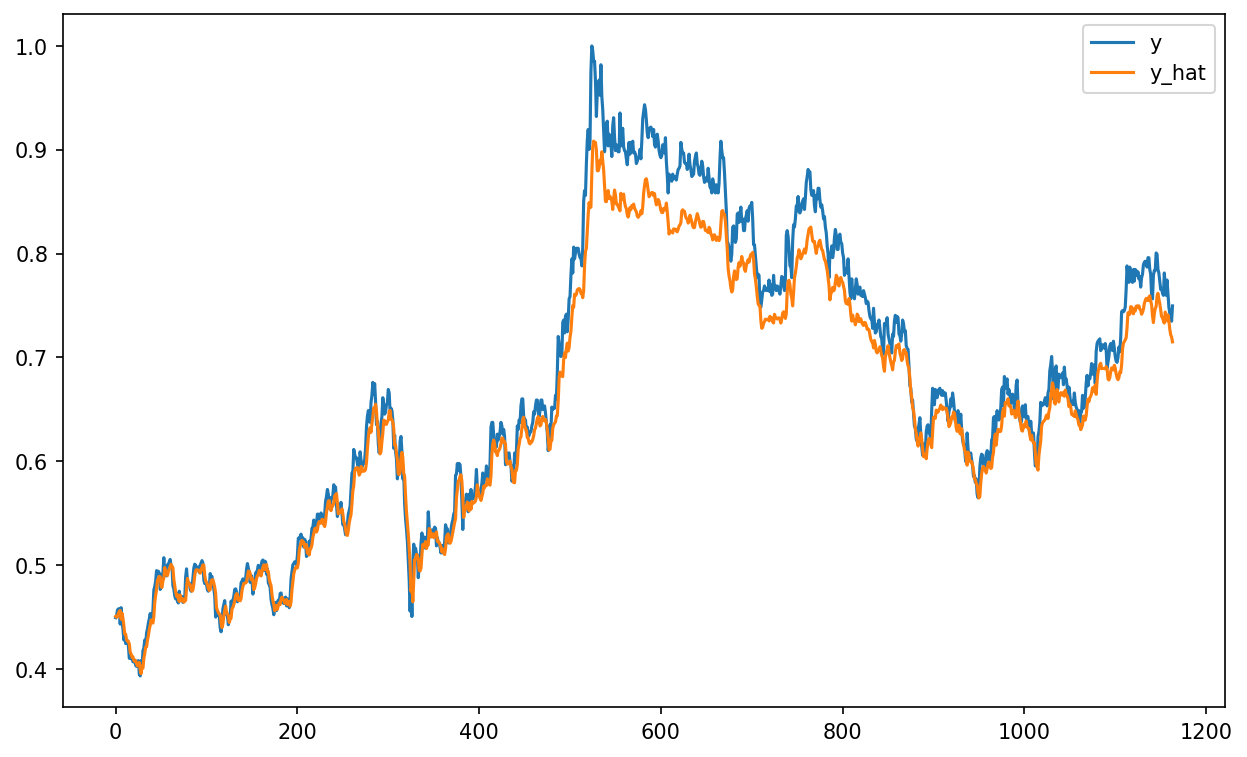

In [35]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(y_test[:, 0], label="y")
plt.plot(y_hat[:, 0], label="y_hat")
plt.legend()
plt.show()